In [30]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from copy import copy




import time
import pickle
import os

SavingFolder = os.path.join(os.getcwd(), 'SavingFolder')

import networkx as nx

from linear_algebra_inZ2 import loss_decoding_gausselim_fast
from graphs import *

from ManyBodiesStabs_funcs import *

# def powerset(iterable, n_min=2):
#     "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
#     s = list(iterable)  # allows duplicate elements
#     return chain.from_iterable(combinations(s, r) for r in range(n_min, len(s)+1))

# Tests on square lattice - edge deletion only

In [4]:
num_dims = 2

L = 100 # 30

num_ps = 7 # 10

p_list = np.linspace(0.3, 0.7, num_ps)
# p_list = np.linspace(0.1, 0.9, num_ps)

num_lattice_samples = 10 # 100
num_subset_samples = 10 #10

max_dist = 9


qbts, edges = get_hypercube_lattice_edges(L, num_dims)
num_qbts = len(qbts)
amat0 = get_adj_mat_from_edges(edges, num_qbts, p_loss=0)


all_Renyi_entropy_data = np.zeros((num_ps, num_lattice_samples*num_subset_samples, 2)).astype(np.uint64)

for p_ix, p_loss in enumerate(p_list):
    print('Starting p_loss index:', p_ix)
    for latt_sampl_ix in range(num_lattice_samples):
        print('     At sample ', latt_sampl_ix*num_subset_samples)
        
        wmat = get_wmat_from_edges(edges, num_qbts, p_loss=p_loss)
        
        for subset_sample_ix in range(num_subset_samples):
            
            max_d = np.random.randint(1, max_dist)
                
            qbts_in_subset = get_random_sphere_qbts_subset(amat0, max_d)
            entropy = get_Renyi_entropy(wmat, qbts_in_subset)
            
            all_Renyi_entropy_data[p_ix, latt_sampl_ix*num_subset_samples + subset_sample_ix, 0] = len(qbts_in_subset)
            all_Renyi_entropy_data[p_ix, latt_sampl_ix*num_subset_samples + subset_sample_ix, 1] = entropy

            
            


Starting p_loss index: 0
     At sample  0



KeyboardInterrupt



In [5]:

# with open(os.path.join(SavingFolder, 'BareLattice_ProbEdges_SRenyivsAsize_L'+str(L)+\
#                          '_dim'+ str(num_dims)+\
#                          '_nump'+str(num_ps)+\
#                          '_maxdist'+str(max_dist)+\
#                          '_numLattSampl'+str(num_lattice_samples)+\
#                          '_numSubsetSampl'+str(num_subset_samples)+\
#                          '.pickle'                 
#                         ) , 'wb') as file:

# pickle.dump([p_list, all_Renyi_entropy_data], file)

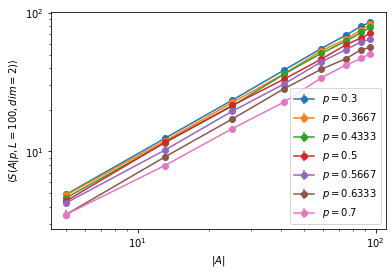

In [229]:
for p_ix, p in enumerate(p_list):
    this_p_data = all_Renyi_entropy_data[p_ix]
    
    unique_vols = np.unique(this_p_data.T[0])
    
    
    entr_means = []
    entr_stds = []
    
    for vol in unique_vols:
        pos_vol = np.where(this_p_data[:, 0] == vol)
        entrs_thisvol = (this_p_data[pos_vol].T)[1]
        this_mean = np.mean(entrs_thisvol)
        this_std = np.std(entrs_thisvol)/np.sqrt(len(entrs_thisvol))
        entr_means.append(this_mean)
        entr_stds.append(this_std)
    
    
    plt.errorbar(unique_vols, entr_means, entr_stds,  label=r'$p=$'+str(np.round(p, 4)), marker='o')

    
plt.xlabel(r'$|A|$')
plt.ylabel(r'$\langle S(A | p, L={}, dim={})\rangle$'.format(L, num_dims))

plt.xscale('log')
plt.yscale('log')    
plt.legend()

# Test fusions on square lattice - star graphs

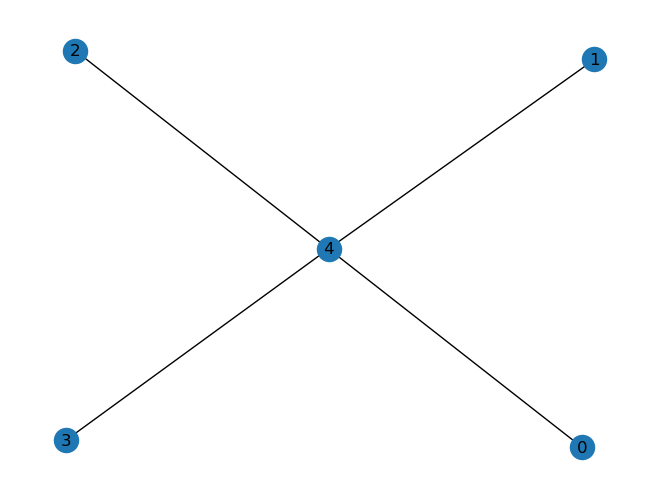

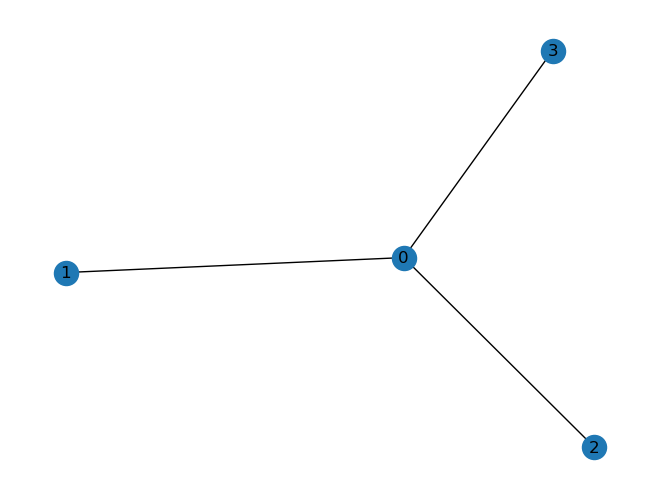

Starting L: 5
    Starting p_fusion_fail index: 0
     At sample  0
    Starting p_fusion_fail index: 1
     At sample  0
    Starting p_fusion_fail index: 2
     At sample  0


KeyboardInterrupt: 

In [3]:
num_dims = 2

L_list = [5, 10, 20, 30, 40, 50, 100, 200]
# L = 10 # 30

num_ps = 11 # 10

p_fail_list = np.linspace(0, 1, num_ps)

num_samples = 100 # 100



# inout_graph = gen_ring_graph(5)
# nx.draw(inout_graph, labels=dict(zip(range(inout_graph.number_of_nodes()),range(inout_graph.number_of_nodes()))))
# plt.show()

# fusion_graph = gen_ring_graph(4)
# nx.draw(fusion_graph, labels=dict(zip(range(fusion_graph.number_of_nodes()),range(fusion_graph.number_of_nodes()))))
# plt.show()

inout_graph = gen_star_graph(5, central_qubit=4)
nx.draw(inout_graph, labels=dict(zip(range(inout_graph.number_of_nodes()),range(inout_graph.number_of_nodes()))))
plt.show()

fusion_graph = gen_star_graph(4)
nx.draw(fusion_graph, labels=dict(zip(range(fusion_graph.number_of_nodes()),range(fusion_graph.number_of_nodes()))))
plt.show()

fusion_rules = {
    0: (1, np.array([+1])),
    1: (0, np.array([-1])),
    2: (3, np.array([-1])),
    3: (2, np.array([+1]))
}




for L_ix, L in enumerate(L_list):
    print('Starting L:', L)

    full_resource_wmat, fused_qubits, in_sites, out_sites = hypercube_fusion_network_with_inout(L, num_dims, fusion_graph, inout_graph, fusion_rules)

    all_data = np.zeros((len(p_fail_list), num_samples))
    
    for p_ix, p_fusion_fail in enumerate(p_fail_list):
        print('    Starting p_fusion_fail index:', p_ix)
    
        for sampl_ix in range(num_samples):
            
            if (sampl_ix%100 == 0):
                print('     At sample ', sampl_ix)

            all_data[p_ix, sampl_ix] = mutual_info_for_probabilistic_fusion_network(full_resource_wmat, fused_qubits, p_fusion_fail, in_sites, out_sites)

#             print('done')
            
    with open(os.path.join(SavingFolder, 'FusionNetwork_2D_probabilisticerasure_Stars_L'+str(L)+\
                         '_dim'+ str(num_dims)+\
                         '_nump'+str(num_ps)+\
                         '_numsamples'+str(num_samples)+\
                         '.pickle'                 
                        ), 'wb') as file:

        pickle.dump([(inout_graph, fusion_graph, fusion_rules), (L, num_dims), p_fail_list, all_data], file)

In [8]:
file_name_L5 = 'FusionNetwork_2D_probabilisticerasure_Stars_L5_dim2_nump11_numsamples100.pickle'

with open(os.path.join(SavingFolder, file_name_L5), 'rb') as file:
    data_L5 = pickle.load(file)
    
    
file_name_L10 = 'FusionNetwork_2D_probabilisticerasure_Stars_L10_dim2_nump11_numsamples100.pickle'

with open(os.path.join(SavingFolder, file_name_L10), 'rb') as file:
    data_L10 = pickle.load(file)
    
    
file_name_L20 = 'FusionNetwork_2D_probabilisticerasure_Stars_L20_dim2_nump11_numsamples100.pickle'

with open(os.path.join(SavingFolder, file_name_L20), 'rb') as file:
    data_L20 = pickle.load(file)
    
    
file_name_L30 = 'FusionNetwork_2D_probabilisticerasure_Stars_L30_dim2_nump11_numsamples100.pickle'

with open(os.path.join(SavingFolder, file_name_L30), 'rb') as file:
    data_L30 = pickle.load(file)
    
    
file_name_L40 = 'FusionNetwork_2D_probabilisticerasure_Stars_L40_dim2_nump11_numsamples100.pickle'

with open(os.path.join(SavingFolder, file_name_L40), 'rb') as file:
    data_L40 = pickle.load(file)
    
    
file_name_L50 = 'FusionNetwork_2D_probabilisticerasure_Stars_L50_dim2_nump11_numsamples100.pickle'

with open(os.path.join(SavingFolder, file_name_L50), 'rb') as file:
    data_L50 = pickle.load(file)
    
    
all_data = [data_L5, data_L10, data_L20, data_L30, data_L40, data_L50]

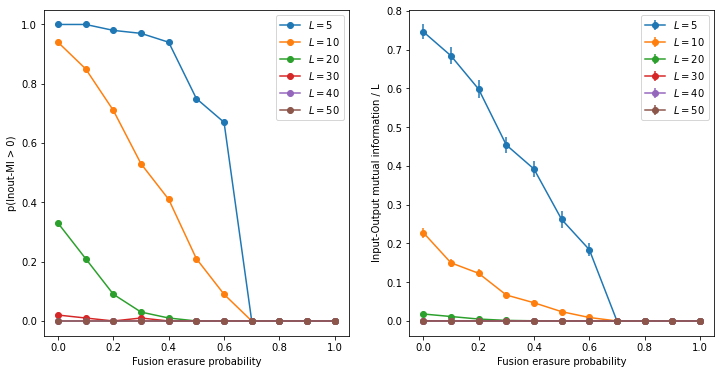

In [28]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for data in all_data:
    (inout_graph, fusion_graph, fusion_rules), (L, num_dims), p_fail_list, mut_info_data = data
       
    n_samples = len(mut_info_data[0])
    
    avg_mut_info = np.array([np.mean(these_samples) for these_samples in mut_info_data])
    std_mut_info = np.array([np.std(these_samples)/np.sqrt(n_samples) for these_samples in mut_info_data])
    
    conn_prob = np.array([np.sum(these_samples>0)/ len(these_samples) for these_samples in mut_info_data])
    
    ax0.plot(p_fail_list, conn_prob,  label=r'$L=$'+str(L), marker='o')
    
    ax1.errorbar(p_fail_list, avg_mut_info/L, std_mut_info/L,  label=r'$L=$'+str(L), marker='o')

    
    ax0.set_xlabel(r'Fusion erasure probability')
    ax0.set_ylabel(r'p(Inout-MI > 0)')
    
    ax0.legend()


    ax1.set_xlabel(r'Fusion erasure probability')
    ax1.set_ylabel(r'Input-Output mutual information / L'.format(L, num_dims))
    
    ax1.legend()
    



    

# Test fusions on square lattice - ring graphs

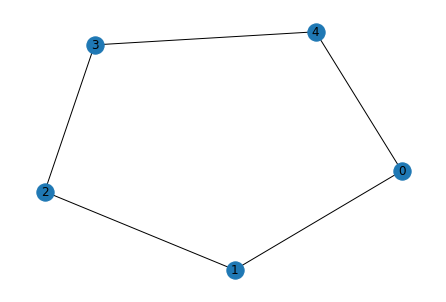

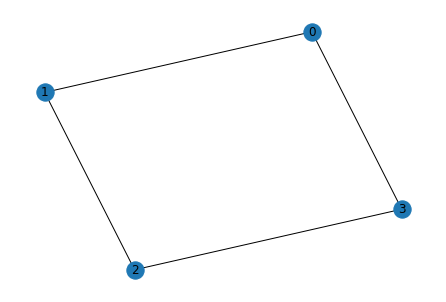

Starting L: 5
    Starting p_fusion_fail index: 0
     At sample  0
    Starting p_fusion_fail index: 1
     At sample  0
    Starting p_fusion_fail index: 2
     At sample  0
    Starting p_fusion_fail index: 3
     At sample  0
    Starting p_fusion_fail index: 4
     At sample  0
    Starting p_fusion_fail index: 5
     At sample  0
    Starting p_fusion_fail index: 6
     At sample  0
    Starting p_fusion_fail index: 7
     At sample  0
    Starting p_fusion_fail index: 8
     At sample  0
    Starting p_fusion_fail index: 9
     At sample  0
    Starting p_fusion_fail index: 10
     At sample  0
Starting L: 12
    Starting p_fusion_fail index: 0
     At sample  0
    Starting p_fusion_fail index: 1
     At sample  0
    Starting p_fusion_fail index: 2
     At sample  0
    Starting p_fusion_fail index: 3
     At sample  0
    Starting p_fusion_fail index: 4
     At sample  0
    Starting p_fusion_fail index: 5
     At sample  0
    Starting p_fusion_fail index: 6
     At sample  

In [32]:
num_dims = 2

L_list = [5, 12, 20, 30, 40]
# L = 10 # 30

num_ps = 11 # 10

p_fail_list = np.linspace(0, 0.4, num_ps)

num_samples = 20 # 100



# inout_graph = gen_ring_graph(5)
# nx.draw(inout_graph, labels=dict(zip(range(inout_graph.number_of_nodes()),range(inout_graph.number_of_nodes()))))
# plt.show()

# fusion_graph = gen_ring_graph(4)
# nx.draw(fusion_graph, labels=dict(zip(range(fusion_graph.number_of_nodes()),range(fusion_graph.number_of_nodes()))))
# plt.show()

inout_graph = gen_ring_graph(5)
nx.draw(inout_graph, labels=dict(zip(range(inout_graph.number_of_nodes()),range(inout_graph.number_of_nodes()))))
plt.show()

fusion_graph = gen_ring_graph(4)
nx.draw(fusion_graph, labels=dict(zip(range(fusion_graph.number_of_nodes()),range(fusion_graph.number_of_nodes()))))
plt.show()

fusion_rules = {
    0: (1, np.array([+1])),
    1: (0, np.array([-1])),
    2: (3, np.array([-1])),
    3: (2, np.array([+1]))
}




for L_ix, L in enumerate(L_list):
    print('Starting L:', L)

    full_resource_wmat, fused_qubits, in_sites, out_sites = hypercube_fusion_network_with_inout(L, num_dims, fusion_graph, inout_graph, fusion_rules)

    all_data = np.zeros((len(p_fail_list), num_samples))
    
    for p_ix, p_fusion_fail in enumerate(p_fail_list):
        print('    Starting p_fusion_fail index:', p_ix)
    
        for sampl_ix in range(num_samples):
            
            if (sampl_ix%100 == 0):
                print('     At sample ', sampl_ix)

            all_data[p_ix, sampl_ix] = mutual_info_for_probabilistic_fusion_network(full_resource_wmat, fused_qubits, p_fusion_fail, in_sites, out_sites)

#             print('done')
            
    with open(os.path.join(SavingFolder, 'FusionNetwork_2D_probabilisticerasure_Rings_L'+str(L)+\
                         '_dim'+ str(num_dims)+\
                         '_nump'+str(num_ps)+\
                         '_numsamples'+str(num_samples)+\
                         '.pickle'                 
                        ), 'wb') as file:

        pickle.dump([(inout_graph, fusion_graph, fusion_rules), (L, num_dims), p_fail_list, all_data], file)

In [33]:
file_name_L5 = 'FusionNetwork_2D_probabilisticerasure_Rings_L5_dim2_nump11_numsamples20.pickle'

with open(os.path.join(SavingFolder, file_name_L5), 'rb') as file:
    data_L5 = pickle.load(file)
    
    
file_name_L12 = 'FusionNetwork_2D_probabilisticerasure_Rings_L12_dim2_nump11_numsamples20.pickle'

with open(os.path.join(SavingFolder, file_name_L12), 'rb') as file:
    data_L12 = pickle.load(file)
    
    
file_name_L20 = 'FusionNetwork_2D_probabilisticerasure_Rings_L20_dim2_nump11_numsamples20.pickle'

with open(os.path.join(SavingFolder, file_name_L20), 'rb') as file:
    data_L20 = pickle.load(file)
    
file_name_L30 = 'FusionNetwork_2D_probabilisticerasure_Rings_L30_dim2_nump11_numsamples20.pickle'

with open(os.path.join(SavingFolder, file_name_L30), 'rb') as file:
    data_L30 = pickle.load(file)
    
    
file_name_L40 = 'FusionNetwork_2D_probabilisticerasure_Rings_L40_dim2_nump11_numsamples20.pickle'

with open(os.path.join(SavingFolder, file_name_L40), 'rb') as file:
    data_L40 = pickle.load(file)
    
    
    
all_data = [data_L5, data_L12, data_L20, data_L40]

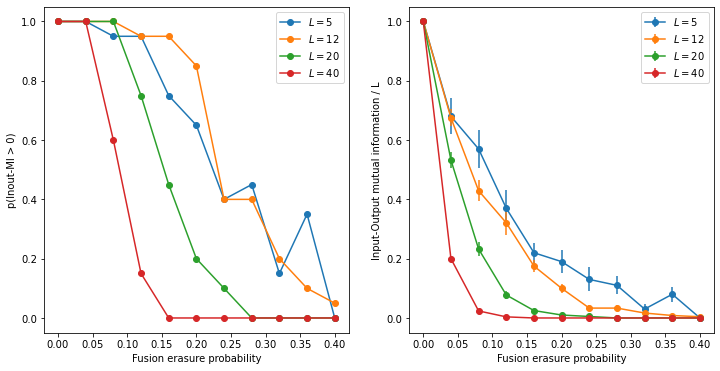

In [34]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for data in all_data:
    (inout_graph, fusion_graph, fusion_rules), (L, num_dims), p_fail_list, mut_info_data = data
       
    n_samples = len(mut_info_data[0])
    
    avg_mut_info = np.array([np.mean(these_samples) for these_samples in mut_info_data])
    std_mut_info = np.array([np.std(these_samples)/np.sqrt(n_samples) for these_samples in mut_info_data])
    
    conn_prob = np.array([np.sum(these_samples>0)/ len(these_samples) for these_samples in mut_info_data])
    
    ax0.plot(p_fail_list, conn_prob,  label=r'$L=$'+str(L), marker='o')
    
    ax1.errorbar(p_fail_list, avg_mut_info/L, std_mut_info/L,  label=r'$L=$'+str(L), marker='o')

    
    ax0.set_xlabel(r'Fusion erasure probability')
    ax0.set_ylabel(r'p(Inout-MI > 0)')
    
    ax0.legend()


    ax1.set_xlabel(r'Fusion erasure probability')
    ax1.set_ylabel(r'Input-Output mutual information / L'.format(L, num_dims))
    
    ax1.legend()
    

# Test fusions on square lattice - ring-fused stars-in

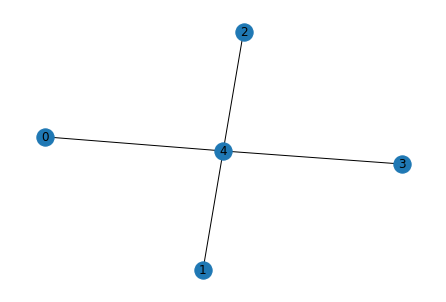

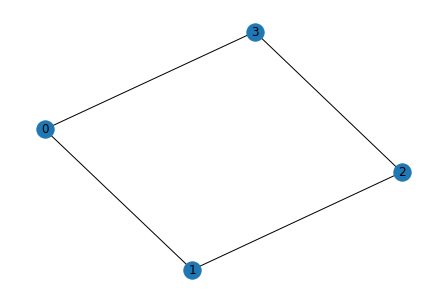

Starting L: 5
    Starting p_fusion_fail index: 0
     At sample  0
    Starting p_fusion_fail index: 1
     At sample  0
    Starting p_fusion_fail index: 2
     At sample  0
    Starting p_fusion_fail index: 3
     At sample  0
    Starting p_fusion_fail index: 4
     At sample  0
    Starting p_fusion_fail index: 5
     At sample  0
    Starting p_fusion_fail index: 6
     At sample  0
    Starting p_fusion_fail index: 7
     At sample  0
    Starting p_fusion_fail index: 8
     At sample  0
    Starting p_fusion_fail index: 9
     At sample  0
    Starting p_fusion_fail index: 10
     At sample  0
Starting L: 10
    Starting p_fusion_fail index: 0
     At sample  0
    Starting p_fusion_fail index: 1
     At sample  0
    Starting p_fusion_fail index: 2
     At sample  0
    Starting p_fusion_fail index: 3
     At sample  0
    Starting p_fusion_fail index: 4
     At sample  0
    Starting p_fusion_fail index: 5
     At sample  0
    Starting p_fusion_fail index: 6
     At sample  

In [43]:
num_dims = 2

L_list = [5, 10, 20, 30, 40]
# L = 10 # 30

num_ps = 11 # 10

p_fail_list = np.linspace(0, 1, num_ps)

num_samples = 20 # 100




inout_graph = gen_star_graph(5, central_qubit=4)
nx.draw(inout_graph, labels=dict(zip(range(inout_graph.number_of_nodes()),range(inout_graph.number_of_nodes()))))
plt.show()

fusion_graph = gen_ring_graph(4)
nx.draw(fusion_graph, labels=dict(zip(range(fusion_graph.number_of_nodes()),range(fusion_graph.number_of_nodes()))))
plt.show()

fusion_rules = {
    0: (1, np.array([+1])),
    1: (0, np.array([-1])),
    2: (3, np.array([-1])),
    3: (2, np.array([+1]))
}




for L_ix, L in enumerate(L_list):
    print('Starting L:', L)

    full_resource_wmat, fused_qubits, in_sites, out_sites = hypercube_fusion_network_with_inout(L, num_dims, fusion_graph, inout_graph, fusion_rules)

    all_data = np.zeros((len(p_fail_list), num_samples))
    
    for p_ix, p_fusion_fail in enumerate(p_fail_list):
        print('    Starting p_fusion_fail index:', p_ix)
    
        for sampl_ix in range(num_samples):
            
            if (sampl_ix%100 == 0):
                print('     At sample ', sampl_ix)

            all_data[p_ix, sampl_ix] = mutual_info_for_probabilistic_fusion_network(full_resource_wmat, fused_qubits, p_fusion_fail, in_sites, out_sites)

#             print('done')
            
    with open(os.path.join(SavingFolder, 'FusionNetwork_2D_probabilisticerasure_StarRings_L'+str(L)+\
                         '_dim'+ str(num_dims)+\
                         '_nump'+str(num_ps)+\
                         '_numsamples'+str(num_samples)+\
                         '.pickle'                 
                        ), 'wb') as file:

        pickle.dump([(inout_graph, fusion_graph, fusion_rules), (L, num_dims), p_fail_list, all_data], file)

In [44]:
file_name_L5 = 'FusionNetwork_2D_probabilisticerasure_StarRings_L5_dim2_nump11_numsamples20.pickle'

with open(os.path.join(SavingFolder, file_name_L5), 'rb') as file:
    data_L5 = pickle.load(file)
    
    
file_name_L10 = 'FusionNetwork_2D_probabilisticerasure_StarRings_L10_dim2_nump11_numsamples20.pickle'

with open(os.path.join(SavingFolder, file_name_L10), 'rb') as file:
    data_L10 = pickle.load(file)
    
    
file_name_L20 = 'FusionNetwork_2D_probabilisticerasure_StarRings_L20_dim2_nump11_numsamples20.pickle'

with open(os.path.join(SavingFolder, file_name_L20), 'rb') as file:
    data_L20 = pickle.load(file)
    
file_name_L30 = 'FusionNetwork_2D_probabilisticerasure_StarRings_L30_dim2_nump11_numsamples20.pickle'

with open(os.path.join(SavingFolder, file_name_L30), 'rb') as file:
    data_L30 = pickle.load(file)
    

file_name_L40 = 'FusionNetwork_2D_probabilisticerasure_StarRings_L40_dim2_nump11_numsamples20.pickle'

with open(os.path.join(SavingFolder, file_name_L40), 'rb') as file:
    data_L40 = pickle.load(file)
    
    
all_data = [data_L5, data_L10, data_L20, data_L30, data_L40]

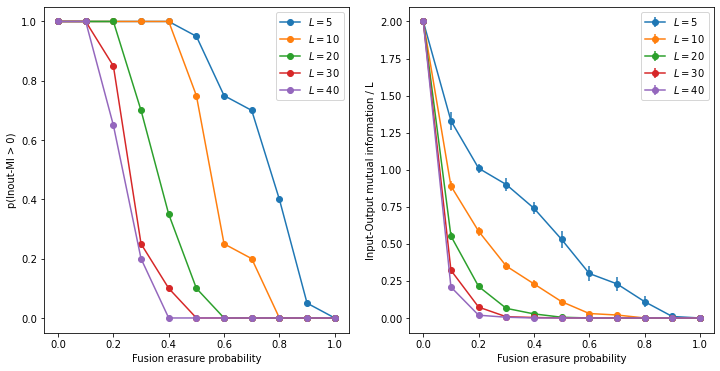

In [45]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for data in all_data:
    (inout_graph, fusion_graph, fusion_rules), (L, num_dims), p_fail_list, mut_info_data = data
       
    n_samples = len(mut_info_data[0])
    
    avg_mut_info = np.array([np.mean(these_samples) for these_samples in mut_info_data])
    std_mut_info = np.array([np.std(these_samples)/np.sqrt(n_samples) for these_samples in mut_info_data])
    
    conn_prob = np.array([np.sum(these_samples>0)/ len(these_samples) for these_samples in mut_info_data])
    
    ax0.plot(p_fail_list, conn_prob,  label=r'$L=$'+str(L), marker='o')
    
    ax1.errorbar(p_fail_list, avg_mut_info/L, std_mut_info/L,  label=r'$L=$'+str(L), marker='o')

    
    ax0.set_xlabel(r'Fusion erasure probability')
    ax0.set_ylabel(r'p(Inout-MI > 0)')
    
    ax0.legend()


    ax1.set_xlabel(r'Fusion erasure probability')
    ax1.set_ylabel(r'Input-Output mutual information / L'.format(L, num_dims))
    
    ax1.legend()

# Test fusions on square lattice - fullyconn-fused stars-in

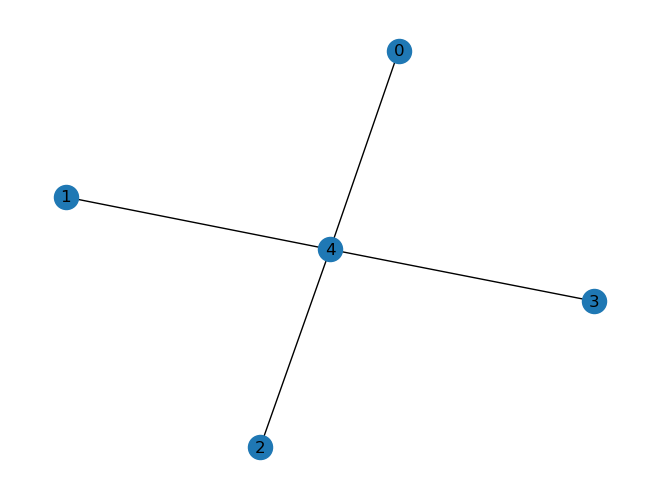

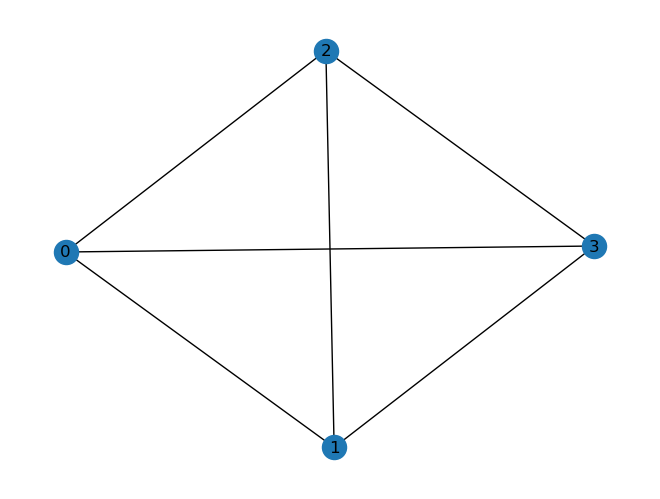

Starting L: 5
    Starting p_fusion_fail index: 0
     At sample  0
    Starting p_fusion_fail index: 1
     At sample  0
    Starting p_fusion_fail index: 2
     At sample  0
    Starting p_fusion_fail index: 3
     At sample  0
    Starting p_fusion_fail index: 4
     At sample  0
    Starting p_fusion_fail index: 5
     At sample  0
    Starting p_fusion_fail index: 6
     At sample  0
    Starting p_fusion_fail index: 7
     At sample  0
    Starting p_fusion_fail index: 8
     At sample  0
    Starting p_fusion_fail index: 9
     At sample  0
    Starting p_fusion_fail index: 10
     At sample  0
Starting L: 10
    Starting p_fusion_fail index: 0
     At sample  0
    Starting p_fusion_fail index: 1
     At sample  0
    Starting p_fusion_fail index: 2
     At sample  0
    Starting p_fusion_fail index: 3
     At sample  0
    Starting p_fusion_fail index: 4
     At sample  0
    Starting p_fusion_fail index: 5
     At sample  0
    Starting p_fusion_fail index: 6
     At sample  

In [27]:
num_dims = 2

L_list = [5, 10, 20]
# L = 10 # 30

num_ps = 11 # 10

p_fail_list = np.linspace(0, 0.4, num_ps)

num_samples = 20 # 100




inout_graph = gen_star_graph(5, central_qubit=4)
nx.draw(inout_graph, labels=dict(zip(range(inout_graph.number_of_nodes()),range(inout_graph.number_of_nodes()))))
plt.show()

fusion_graph = gen_fullyconnected_graph(4)
nx.draw(fusion_graph, labels=dict(zip(range(fusion_graph.number_of_nodes()),range(fusion_graph.number_of_nodes()))))
plt.show()

fusion_rules = {
    0: (1, np.array([+1])),
    1: (0, np.array([-1])),
    2: (3, np.array([-1])),
    3: (2, np.array([+1]))
}




for L_ix, L in enumerate(L_list):
    print('Starting L:', L)

    full_resource_wmat, fused_qubits, in_sites, out_sites = hypercube_fusion_network_with_inout(L, num_dims, fusion_graph, inout_graph, fusion_rules)

    all_data = np.zeros((len(p_fail_list), num_samples))
    
    for p_ix, p_fusion_fail in enumerate(p_fail_list):
        print('    Starting p_fusion_fail index:', p_ix)
    
        for sampl_ix in range(num_samples):
            
            if (sampl_ix%100 == 0):
                print('     At sample ', sampl_ix)

            all_data[p_ix, sampl_ix] = mutual_info_for_probabilistic_fusion_network(full_resource_wmat, fused_qubits, p_fusion_fail, in_sites, out_sites)

#             print('done')
            
    with open(os.path.join(SavingFolder, 'FusionNetwork_2D_probabilisticerasure_StarFullyConn_L'+str(L)+\
                         '_dim'+ str(num_dims)+\
                         '_nump'+str(num_ps)+\
                         '_numsamples'+str(num_samples)+\
                         '.pickle'                 
                        ), 'wb') as file:

        pickle.dump([(inout_graph, fusion_graph, fusion_rules), (L, num_dims), p_fail_list, all_data], file)

In [28]:
file_name_L5 = 'FusionNetwork_2D_probabilisticerasure_StarFullyConn_L5_dim2_nump11_numsamples20.pickle'

with open(os.path.join(SavingFolder, file_name_L5), 'rb') as file:
    data_L5 = pickle.load(file)
    
    
file_name_L10 = 'FusionNetwork_2D_probabilisticerasure_StarFullyConn_L10_dim2_nump11_numsamples20.pickle'

with open(os.path.join(SavingFolder, file_name_L10), 'rb') as file:
    data_L10 = pickle.load(file)
    
    
file_name_L20 = 'FusionNetwork_2D_probabilisticerasure_StarFullyConn_L20_dim2_nump11_numsamples20.pickle'

with open(os.path.join(SavingFolder, file_name_L20), 'rb') as file:
    data_L20 = pickle.load(file)
    
    
    
all_data = [data_L5, data_L10, data_L20]

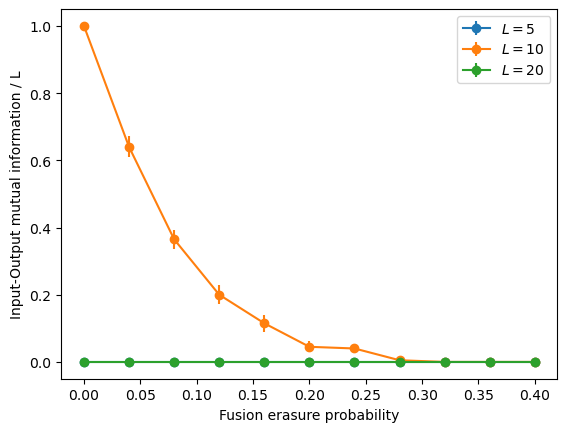

In [29]:
for data in all_data:
    (inout_graph, fusion_graph, fusion_rules), (L, num_dims), p_fail_list, mut_info_data = data
       
    n_samples = len(mut_info_data[0])
    
    avg_mut_info = np.array([np.mean(these_samples) for these_samples in mut_info_data])
    std_mut_info = np.array([np.std(these_samples)/np.sqrt(n_samples) for these_samples in mut_info_data])
    
    plt.errorbar(p_fail_list, avg_mut_info/L, std_mut_info/L,  label=r'$L=$'+str(L), marker='o')


    plt.xlabel(r'Fusion erasure probability')
    plt.ylabel(r'Input-Output mutual information / L'.format(L, num_dims))

#     plt.xscale('log')
#     plt.yscale('log')
#     plt.ylim((1e-4, 10e-0))
    plt.legend()